In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt

## Load data

In [2]:
train = pd.read_json('data/music_reviews_train.json', lines=True)
dev = pd.read_json('data/music_reviews_dev.json', lines=True)
test = pd.read_json('data/music_reviews_test_masked.json', lines=True)

train = train[['reviewText', 'sentiment']]
dev = dev[['reviewText', 'sentiment']]
test = test[['reviewText', 'sentiment']]

train.replace(np.nan, '', regex=True, inplace=True)
dev.replace(np.nan, '', regex=True, inplace=True)
test.replace(np.nan, '', regex=True, inplace=True)

In [3]:
#X_train, y_train = train['reviewText'], train['sentiment']
#X_train = X_train.replace(np.nan, '', regex = True)
#X_dev, y_dev = dev['reviewText'], dev['sentiment']
#X_dev = X_dev.replace(np.nan, '', regex = True)

### Data Exploration

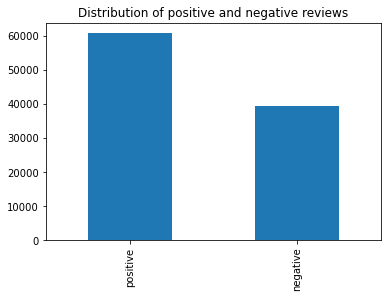

In [4]:
train['sentiment'].value_counts().plot(kind='bar')

plt.title('Distribution of positive and negative reviews')    
plt.show()

In [5]:
train.describe()

,reviewText,sentiment
count,100000,100000
unique,88519,2
top,Great song,positive
freq,305,60783


In [6]:
train.groupby('sentiment').describe()

reviewText                        
               count unique         top freq
sentiment                                   
negative       39217  35705          ok   62
positive       60783  52928  Great song  304

### Data preprocessing

Remove punctuation and stopwords

In [7]:
import string
from nltk.corpus import stopwords

def preprocess_text(text):
    puncs = string.punctuation
    stops = stopwords.words('english')
    no_punc = [token for token in text if token not in puncs]                               #remove punctuations
    no_punc = ''.join(no_punc)
    no_stops = [word.lower() for word in no_punc.split() if word.lower() not in stops]      #remove stopwords
    
    return ' '.join(no_stops)

In [8]:
# View how the text is cleaned
train['reviewText'].head(5).apply(preprocess_text)

0    creative love music words message favorite son...
1          tape hardly understood listed sale good bad
2    buy cd buy mp3 album download longer available...
3    love dallas holms music voice thank attending ...
4                    great memories early years christ
Name: reviewText, dtype: object

In [9]:
train_clean = train['reviewText'].apply(preprocess_text).tolist()
dev_clean = dev['reviewText'].apply(preprocess_text).tolist()
test_clean = test['reviewText'].apply(preprocess_text).tolist()

### Bag of Words (BOW)

We have to convert each reviewText into a vector through a BOW representation.

Each will the dimension as the unique words in the reviews. **CountVectorizer** will convert the reviews into a matrix of word counts. The columns are a word (entire vocab) and the rows are each review, and 1 is present if that word is present in the reviewText.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(min_df=2).fit(train_clean)
print(f'Vocab size: {len(bow_transformer.vocabulary_)}')

Vocab size: 41181


In [11]:
# Apply transformation to data
train_bow = bow_transformer.transform(train_clean)
dev_bow = bow_transformer.transform(dev_clean)
test_bow = bow_transformer.transform(test_clean)

In [12]:
print(f'Shape of sparse matrix: {train_bow.shape}')

Shape of sparse matrix: (100000, 41181)


### Weights

**TF-IDF**

Calculate the number of times a word appears in a sentence divided by the total number of words in the sentence.

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(train_bow)

In [14]:
train_tfidf = tfidf_transformer.transform(train_bow)
dev_tfidf = tfidf_transformer.transform(dev_bow)
test_tfidf = tfidf_transformer.transform(test_bow)
print(train_tfidf.shape)

(100000, 41181)


### Model training and evaluation

In [15]:
# Train a NaiveBayes model on the traning vectorized reviews

from sklearn.naive_bayes import MultinomialNB
NaiveBayes = MultinomialNB().fit(train_tfidf, train['sentiment'])

In [16]:
# Predict the sentences in the dev set

predictions = NaiveBayes.predict(dev_tfidf)
from sklearn.metrics import accuracy_score
accuracy_score(predictions, dev['sentiment'])

0.8758

### Output predictions on test to csv

In [17]:
test_pred = NaiveBayes.predict(test_tfidf)

In [18]:
label2idx = {'negative': 0, 'positive':1}
#labels to numeric
test_pred_numeric = list(map(label2idx.get, test_pred))

In [20]:
#kaggle_df = pd.DataFrame(test_pred_numeric, columns=['prediction'])
#kaggle_df.to_csv('kaggle_test_predictions.csv', index_label='id')